[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/git-sunao/path-integral/blob/main/test.ipynb)

In [1]:
import jax.numpy as jnp
from jax import jit
from jax import grad
from jax import vmap
from jax import jacobian
from jax import jacfwd, jacrev
from jax import vjp
from jax.lax import scan
import matplotlib.pyplot as plt

In [2]:
# Run this if in Google Colab
# !git clone https://github.com/git-sunao/path-integral.git
# %cd path-integral
# !pip install -r requirements.txt

## Development notebook 1
### Notation

$\providecommand{\d}{\mathrm{d}}$

$$
Z = \int_{-\infty}^\infty \d x I = \int_{-\infty}^\infty \d x e^{i\phi} 
$$

where the integrand $I$ is highly oscilating function $I=e^{i\phi(x)}$, we can also define the real and imaginary parts of function $i\phi(x)$.

$$
i\phi(x) = h(x) + i H(x)
$$

This is the notation adopted in [Feldbrugge's papers](https://jfeldbrugge.github.io/Picard_Lefschetz_Integrator/).

Other paper uses different notation. For example, [Atis's paper](https://arxiv.org/pdf/2307.11199) uses 

$$
i\phi = -S_{\rm eff}
$$

and physical action

$$
i\phi(x) = i S
$$

### Example problem
We first work on the 1 dimensional problem with $i\phi(x)=ix^2$, where the analytic solution is available

$$
Z = \int_{-\infty}^\infty \d x e^{ix^2} = (1+i)\sqrt{\pi/2}
$$

The idea of the Picard Lefschetz thimble approach is to analytically continue the integration domain from the real space $x$ to the complex space $z$ and to deform the integration path along which the integrand is a non-oscilating function.

$$
Z = \int_{\mathcal{J}} \d z e^{iz^2}
$$

The flow equation to get Picard-Lefschetz (PL) thimble $\mathcal{J}$ is defined as

$$
\frac{\d z}{\d \sigma} = \overline{\frac{\partial\phi}{\partial z}}
$$

where $\overline{X}$ is the conjugate of value $X$, and $\sigma$ parametrize the flow of the path.

However the integral measure on the PL thimble is difficult to get. So, as discussed in Atis's paper, we instead use the following expression
$$
Z = \int_{-\infty}^\infty \d x \frac{\partial z}{\partial x} e^{i\phi}
$$
where $J=\frac{\partial z}{\partial x}$ is the Jacobian from $x$ to $z$. This expression is nice because the integral is performed on $x$ while the integrand is non-oscilating function, and also because the integral measure can be captured by keeping the evolution of the Jacobian along the flow, which can be easily done with the auto-differencial package like jax.

In [3]:
def action_iphi(z):
    iphi = 1j*z**2
    return iphi

def action_h(z):
    ip = action_iphi(z)
    h = jnp.real(ip) + 0.0j
    return h

def action_Seff(z):
    seff = -action_iphi(z)
    return seff

def integrand(z):
    return jnp.exp(action_iphi(z))

# # corresponding gradients
grad_iphi = grad(action_iphi, holomorphic=True)
grad_h    = grad(action_h, holomorphic=True)
grad_Seff = grad(action_Seff, holomorphic=True)

In [4]:
def flow_step(z, ds, thre=0.1):
    dSdz = grad_Seff(z)
    z = z + ds*jnp.conj(dSdz)
    # z = z - ds*dSdz
    # z = z - ds*jnp.conj(dSdz)
    # z = z + ds * jnp.conj(dSdz)
    # dhdz = grad_h(z)
    # z = z + ds*dhdz
    # z = z - ds*jnp.conj(dhdz)
    return z

def flow_n_steps(x, ds, n_step):
    z = x.astype(complex)
    fnc = lambda z, null: (flow_step(z, ds), null)
    z, null = scan(fnc, z, length=n_step)
    return z

def flow_n_steps_with_jac(x, ds, n_step):
    z = flow_n_steps(x, ds, n_step)

    # This is not an appropriate way to calculate the Jacob
    # because the function flow_n_steps is **not** holomorphic.
    # j = jacrev(flow_n_steps, argnums=0, holomorphic=True)(z, ds, n_step)

    # We here define the jacobian of the flow_n_steps by split the 
    # function into real and imaginary parts.
    # jr = jacrev(lambda x: jnp.real(flow_n_steps(x, ds, n_step)), argnums=0)(x)
    # ji = jacrev(lambda x: jnp.imag(flow_n_steps(x, ds, n_step)), argnums=0)(x)
    # j  = jr + ji*1j

    # The above code is okay, but could be slow 
    # because it calls flow_n_steps twice.
    # Here we define already splitted version, 
    # and compute the jacobian on it.
    # Not sure if this works for ndim>=2.
    def split(x, ds, n_step):
        f = flow_n_steps(x, ds, n_step)
        return jnp.real(f), jnp.imag(f)
    j = jacobian(split, argnums=0)(x, ds, n_step)
    j = j[0] + j[1]*1j

    return z, j

vflow = vmap(flow_n_steps_with_jac, (0,None,None), 0)

CPU times: user 791 ms, sys: 41 ms, total: 832 ms
Wall time: 856 ms


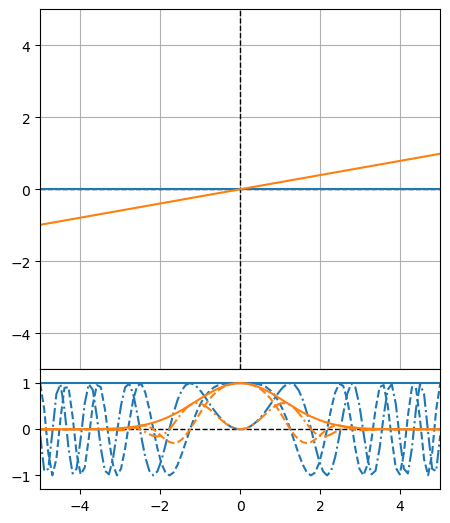

In [5]:
x = jnp.linspace(-5, 5, 100)
z = x.astype(complex)
%time z_pl, j = vflow(x, 1e-3, 100)

fig = plt.figure(figsize=(5,6))
ax1 = fig.add_axes((.1,.3,.8,.6))
ax1.set_xlim(x.min(),x.max())
ax1.set_ylim(x.min(),x.max())
ax1.axhline(0, color='black', lw=1, ls='--')
ax1.axvline(0, color='black', lw=1, ls='--')
ax1.grid()
ax1.set_xlabel('')
ax2 = fig.add_axes((.1,.1,.8,.2), sharex=ax1)
ax2.axhline(0, color='black', lw=1, ls='--')
for zin, color in zip([z, z_pl], ['C0', 'C1']):
    ax1.plot(zin.real, zin.imag)
    i = integrand(zin)
    ax2.plot(x, jnp.real(i), color=color, ls='--')
    ax2.plot(x, jnp.imag(i), color=color, ls='-.')
    ax2.plot(x, jnp.abs (i), color=color, ls='-')
ax2.set_ylim(-1.3, 1.3)
plt.show()

In [6]:
x = jnp.linspace(-5, 5, 100)
%time z_pl, j = vflow(x, 1e-3, 100)

# PL evaluation
z_pl = jnp.trapezoid(integrand(z_pl) * j, x)

# Analytical result
z_ana= (1+1j)*jnp.sqrt(jnp.pi/2)

print(f"PL : {z_pl} ")
print(f"Ana: {z_ana}")

CPU times: user 203 ms, sys: 14.3 ms, total: 218 ms
Wall time: 219 ms
PL : (1.2533109188079834+1.2533082962036133j) 
Ana: (1.2533141374588013+1.2533141374588013j)
